### Gaussian mixture 

## $\pi (x) = \frac{1}{2(2\pi)^{d/2}} \left( e ^{\frac{-| x-a|^2}{2}}  + e ^{\frac{-| x+a|^2}{2}} \right), \quad x \in\mathbb R^d$

$U(x) = \frac{1}{2} \|x - a\|_2^2 - \text{log}(1 + e^{-2x^\top a})$

$\nabla U(x) = x-a +2a(1 + e^{2 x^\top a})^{-1}$

$ m = 1 - \|a \|_2^2 \quad $ (strongly convex function)

$M = 1 \quad$  (Lipschitz continuous gradient)

$a = (\frac{1}{\sqrt{2d}}, \dots, \frac{1}{\sqrt{2d}})$

##### Setup:

d = 8

n = 1000

N = 50000

N_train = 50

N_test = 100

polynomials_max_deg = 1

$\tilde{n} = 100$

$f(x) = \sum_{i=1}^{d}x_i$

$K = 1$

In [1]:
import numpy as np
import scipy 
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from scipy.misc import comb
from matplotlib import pyplot as plt
from scipy.special import hermitenorm
from tqdm import tqdm
from numpy.polynomial.hermite_e import HermiteE
import matplotlib.mlab as mlab
%matplotlib inline
from joblib import Parallel, delayed
from scipy.optimize import minimize
from itertools import product
import sys
import warnings
from sklearn import linear_model
import math
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from numpy.random import normal  
import timeit

### Parameters inicialization, ULA algorithm

In [2]:
d = 8
a = np.ones((d,1)) / np.sqrt(2*d)

def f_grad(x):
    return x-a+2*a/(1 + np.exp(2* (x.T @ a)))

def generate_lmc(a,d,N):
    h = 0.1
    K = 50000
    vkh = np.empty((K + N,d,1))
    ksi = np.random.randn(K+N,d,1)
    vkh[0] = (np.random.normal(0,1,d)).reshape(d,1)
    for i in range(1,K+N):
        grad = f_grad(vkh[i-1])
        vkh[i] = vkh[i-1] - h*grad + np.sqrt(2*h) * ksi[i]
    return vkh[K:], ksi[K:]

### Sample generation

In [3]:
np.random.seed(2342)
X, Z = generate_lmc(a,d, 100000)

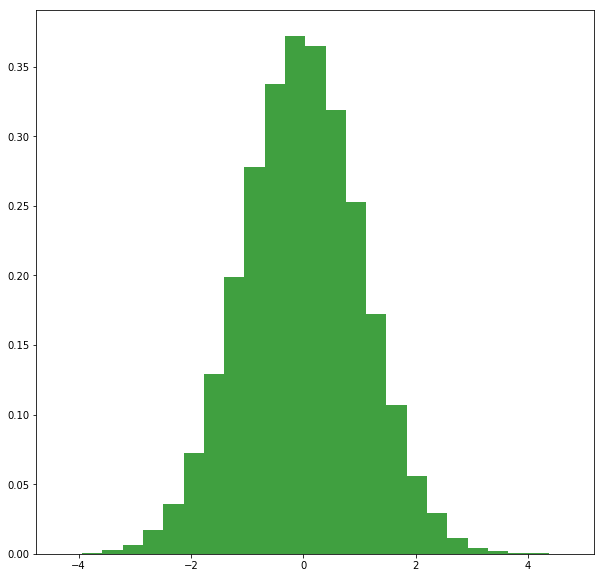

In [4]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(X[:,1].reshape(-1,1), 25, density=True, facecolor='g', alpha=0.75)
x = np.linspace(-5,5,100)
plt.show()

### Ordinary weighted estimator with $$f(x) = x$$

In [5]:
def local_weighted_estimator(X):
    return X.sum(axis = 1).mean()

In [6]:
print ("Weighted estimator = ",local_weighted_estimator(X))

Weighted estimator =  -0.012067186009939033


### Generation of N_train independent paths

In [286]:
def generate_lmc_from_initial(x_initial,a,d,N):
    h = 0.1
    vkh = np.empty((N,d,1))
    vkh_grad = np.empty((N,d,1))
    ksi = np.random.randn(N,d,1)
    vkh[0] = x_initial
    for i in range(1,N):
        grad = f_grad(vkh[i-1])
        vkh_grad[i-1] = grad
        vkh[i] = vkh[i-1] - h*grad + np.sqrt(2*h) * ksi[i]
    vkh_grad[-1] = f_grad(vkh[-1])
    return vkh, ksi, vkh_grad


def generate_paths(x_initial,N_train,a,d,N):
    XX = []
    ZZ = []
    GG = []
    for i in range(N_train):
        X, Z, G = generate_lmc_from_initial(x_initial[-i],a,d,N)
        XX.append(X)
        ZZ.append(Z)
        GG.append(G)
    return np.array(XX),np.array(ZZ), np.array(GG)

In [234]:
np.random.seed(123)
XX, ZZ, _ = generate_paths(X,2000,a,d,1000)

### Generate validation path

In [235]:
np.random.seed(42)
X_validate, Z_validate = generate_lmc_from_initial(X[-5000],a,d,1000)

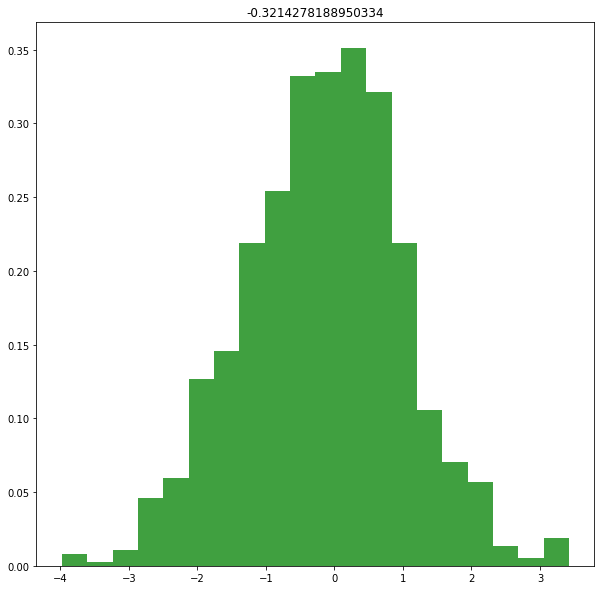

In [236]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(X_validate[:,1].reshape(-1,1), 20, density=True, facecolor='g', alpha=0.75)
x = np.linspace(-5,5,100)
plt.title((local_weighted_estimator(X_validate)))
plt.show()

### (normalized) Hermite polynomials

In [237]:
def generate_k_vec(d, K):
    r = list(range(K+1))
    k = []
    for roll in product(r, repeat = d):
        k.append(list(roll))
    k.remove([0,0,0,0,0,0,0,0])
    return k
def H(k, x):
    h = hermitenorm(k)(x) /  np.sqrt(math.factorial(k))
    return h
def Hermite_val(k_vec,x_vec):
    P = 1.0
    d = x_vec.shape[0]
    for i in range(d):
        P = P * H(k_vec[i],x_vec[i])
    return P

In [238]:
k_comb = np.zeros((d,d), dtype=np.int16)
for i in range(d):
    k_comb[i,i] = 1

### Reduced variant

## Fitting linear regression for 

## $Q_{p,l}(x) = \mathbb{E} \left[f(X_p) | X_l = x\right] = G_{p-l}(x) = \mathbb{E} \left[ f(\varPhi ^{p-l} (x, \xi))\right]$


### $\forall l: \quad G_r(x) = \mathbb{E} \left[f(X_{l+r}) | X_l = x \right] $

### Algorithm (trajectory + all variations):

## $\hat{G}_r = argmin_{\psi \in \Psi} \sum_{s = 1}^{N_{train}} \sum_{l = N + 1}^{N+n-r} \left| f(X_{l+r}^{(s)}) - \psi(X_l^{(s)})\right|^2$

### where $\quad  1 \leq r \leq n-1$

## $\hat{G}_0(x) = f(x)$

In [273]:
deg_pol = 9
def pol_ar_1d(x): #x.shape = (8,1)
    return np.array([1,x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]])

def generate_X(XX, l):
    N_train = XX.shape[0]
    N = XX.shape[1]
    d = XX.shape[2]
    X = np.empty((N_train, deg_pol))
    X[:,0] = np.ones(N_train)
    X[:,1] = XX[:,l,0].squeeze()
    X[:,2] = XX[:,l,1].squeeze()
    X[:,3] = XX[:,l,2].squeeze()
    X[:,4] = XX[:,l,3].squeeze()
    X[:,5] = XX[:,l,4].squeeze()
    X[:,6] = XX[:,l,5].squeeze()
    X[:,7] = XX[:,l,6].squeeze()
    X[:,8] = XX[:,l,7].squeeze()
    return X 


def generate_y(XX,ZZ,l,n_tilde = 60):
    N_train = XX.shape[0]
    N = XX.shape[1]
    d = XX.shape[2]
    y = np.zeros(N_train)
    for s in range(N_train):
        y[s] = XX[s][l:l+n_tilde].sum()
    return y

def q_l_fit(XX,ZZ):
    N_train = XX.shape[0]
    N = XX.shape[1]
    d = XX.shape[2]
    Betas = np.zeros((N,deg_pol))
    for l in tqdm(range (N)):
        X = generate_X(XX,l)
        y = generate_y(XX,ZZ,l)
        beta = np.linalg.inv(X.T @ X) @ X.T @ y
        Betas[l] = beta
    return Betas

def q_l_predict(x,l, Betas,k):
    x_pol = pol_ar_1d(x)
    beta = Betas[l]
    return (x_pol @ beta)

In [274]:
Betas = q_l_fit(XX,ZZ)

100%|██████████| 1000/1000 [00:05<00:00, 179.69it/s]


In [275]:
degrees = np.zeros((d+1,d), dtype=np.int16)
for i in range(1,d+1):
    degrees[i,i-1] = 1

In [276]:
def a_lk(X,l,k_vec, Betas):
    d = 8
    h = 0.1
    S = 0
    x_hat = X[l-1] - h*f_grad(X[l-1])
    Small_s = np.zeros(d)
    for ind,deg in enumerate(degrees):
        Small_s[:] = 0
        for d, i in enumerate(deg):
            for t in range (i+1):
                for s in range (int(t/2 +1)):
                    if (k_vec[d] == t - 2*s):
                        Small_s[d] = Small_s[d] + comb(N=i, k = t, exact = True) * x_hat[0]**(i-t) * \
                        math.factorial(t)*1/math.factorial(s)*1 / np.sqrt(math.factorial(t-2*s)) *np.sqrt(2*h)**t /2**s
                    else:
                        pass
        S = S + Betas[l,ind] * Small_s.prod()
    return S

def M_bias(k_vec,X,Z, Betas):
    N = X.shape[0]
    S = 0
    for l in range (N):
        s = a_lk(X,l,k_vec, Betas)* Hermite_val(k_vec,Z[l])
        S = S + s
    return S/N

def estimator_bias(k,XX,ZZ,Betas,first, last):
    M_results = Parallel(n_jobs=-1)(delayed(M_bias)(k,XX[i],ZZ[i],Betas)for i in range(first, last))
    return np.array(M_results).reshape(-1)

def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

### check formula ( full)

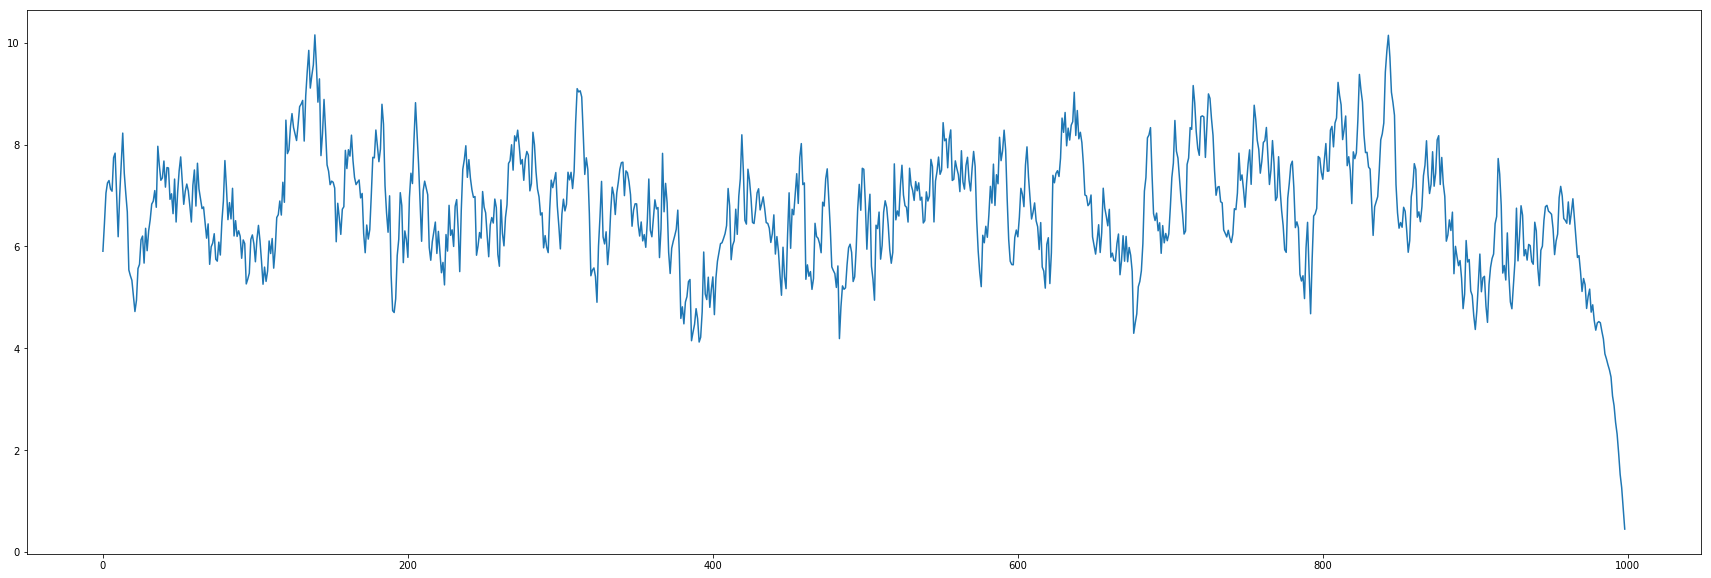

In [277]:
plot_a_lk = []
for i in range (1,XX.shape[1]):
    plot_a_lk.append(a_lk(XX[0],i,k_comb[0], Betas))
plot_a_lk = np.array(plot_a_lk)
plt.figure(figsize=(30,10))
plt.plot(plot_a_lk)

In [262]:
time_1 = timeit.default_timer()
print ("P =",local_weighted_estimator(X_validate))
for i in range(len(k_comb)):
    print ("M ({}) = {} [Time:{}]".format(k_comb[i],M_bias(k_comb[i],X_validate,Z_validate,Betas),
                                           timeit.default_timer()-time_1))

P = -0.3214278188950334
M ([1 0 0 0 0 0 0 0]) = [0.01935827] [Time:3.4045366360078333]
M ([0 1 0 0 0 0 0 0]) = [-0.15861864] [Time:7.090459094004473]
M ([0 0 1 0 0 0 0 0]) = [-0.24940846] [Time:10.584534606998204]
M ([0 0 0 1 0 0 0 0]) = [-0.09717645] [Time:14.032243308000034]
M ([0 0 0 0 1 0 0 0]) = [0.39664652] [Time:17.635664704008377]
M ([0 0 0 0 0 1 0 0]) = [-0.17229105] [Time:21.062471400000504]
M ([0 0 0 0 0 0 1 0]) = [-0.09041112] [Time:24.483755990004283]
M ([0 0 0 0 0 0 0 1]) = [0.16752272] [Time:28.194343833005405]


In [263]:
X = XX[27]
Z = ZZ[27]
time_1 = timeit.default_timer()
print ("P =",local_weighted_estimator(X))
for i in range(len(k_comb)):
    print ("M ({}) = {} [Time:{}]".format(k_comb[i],M_bias(k_comb[i],X,Z,Betas),timeit.default_timer()-time_1))

P = -0.0768305988818712
M ([1 0 0 0 0 0 0 0]) = [0.34110211] [Time:3.5440302200004226]
M ([0 1 0 0 0 0 0 0]) = [0.21223491] [Time:6.26738077099435]
M ([0 0 1 0 0 0 0 0]) = [-0.07498435] [Time:9.000122583995108]
M ([0 0 0 1 0 0 0 0]) = [0.10473937] [Time:11.72985910299758]
M ([0 0 0 0 1 0 0 0]) = [-0.12253121] [Time:14.447667961998377]
M ([0 0 0 0 0 1 0 0]) = [0.13967183] [Time:17.166775947000133]
M ([0 0 0 0 0 0 1 0]) = [-0.47157015] [Time:19.85168545799388]
M ([0 0 0 0 0 0 0 1]) = [-0.04634987] [Time:22.55908372400154]


## Check on test sample

In [287]:
np.random.seed(987)
X, Z = generate_lmc(a,d,100000)
XX_test, ZZ_test, GG_test = generate_paths(X,100,a,d,1000)
P_test = estimator(XX_test)

print ('Variance of Pi = ',P_test.var(dtype=np.float64,ddof = 1))

# np.save('GM_8d_XX_test.npy', XX_test)
# np.save('GM_8d_ZZ_test.npy', ZZ_test)

100%|██████████| 100/100 [00:00<00:00, 23124.40it/s]

Variance of Pi =  0.3247338706361704


In [250]:
# XX_test = np.load('GM_8d_XX_test.npy')
# ZZ_test = np.load('GM_8d_ZZ_test.npy')
# P_test = estimator(XX_test)

In [266]:
M_results_algo_2 = np.empty((len(k_comb), XX_test.shape[0]))

for i,k in enumerate(k_comb):
    M_results_algo_2[i] = estimator_bias(k,XX_test,ZZ_test,Betas, 0, 100)

In [208]:
M_results_algo_1 = np.load('../VR-MCMC/Gaussian_mixture_8d(truncated)/GM(2d)_M_results_test_.npy')

In [279]:
print ('Variance of Pi = ',(P_test - M_results_algo_1.sum(axis = 0)).var(ddof = 1))
print ('Variance of Pi = ',(P_test - M_results_algo_2.sum(axis = 0)).var(ddof = 1))

Variance of Pi =  0.00978211277392896
Variance of Pi =  0.016168075573709376


In [283]:
print ('c = ',P_test.var(dtype=np.float64,ddof = 1) / (P_test - M_results_algo_1.sum(axis = 0)).var(ddof = 1))
print ('c = ',P_test.var(dtype=np.float64,ddof = 1) / (P_test - M_results_algo_2.sum(axis = 0)).var(ddof = 1))

c =  33.19670076812474
c =  20.08488079831928


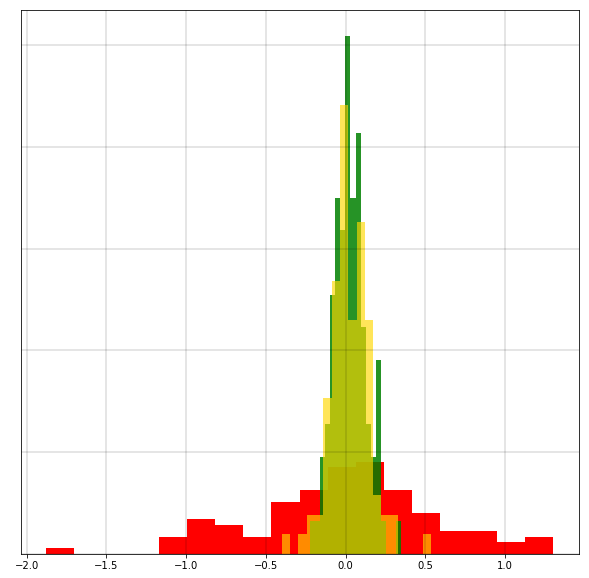

In [278]:
plt.figure(figsize=(10,10))
plt.hist(P_test.reshape(-1,1),18, facecolor='r', density=True,
                            alpha=1, label="Distribution of $\pi$")

plt.hist((P_test-M_results_algo_1.sum(axis = 0)).reshape(-1,1), 18, density=True, facecolor='g', 
                            alpha=0.85, label="Distribution of $\pi - M^1_N$")

plt.hist((P_test-M_results_algo_2.sum(axis = 0)).reshape(-1,1), 18, density=True, facecolor='gold', 
                            alpha=0.65, label="Distribution of $\pi - M^1_N$")
plt.grid(linestyle='-', linewidth=0.2, color='black')
plt.tick_params(
    axis='y',
    color = 'w',
    labelcolor = 'w',
    which='both')
plt.show()

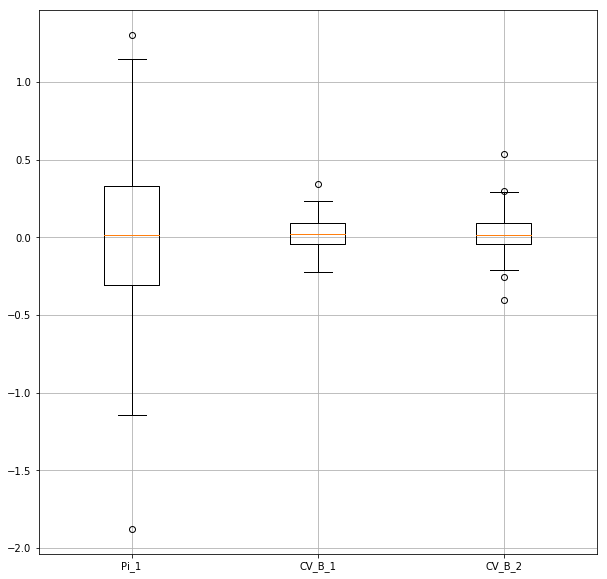

In [302]:
plt.figure(figsize=(10,10))

# generate some random test data
all_data = [P_test, 
            P_test - M_results_algo_1.sum(axis = 0),
            P_test - M_results_algo_2.sum(axis = 0)]

# plot violin plot
plt.boxplot(all_data)
plt.xticks(np.arange(1,4), ('Pi_1', 'CV_B_1','CV_B_2'))
plt.grid()
plt.show()

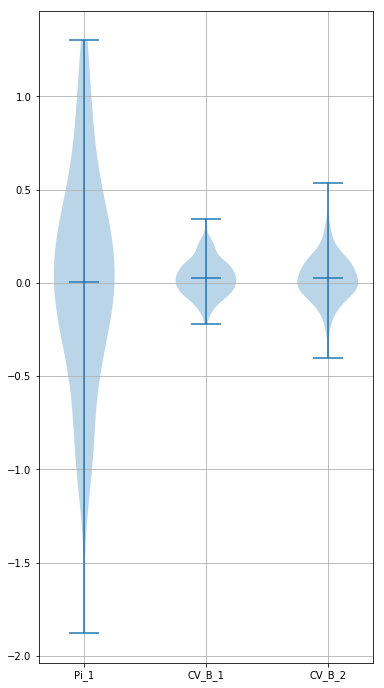

In [303]:
plt.figure(figsize=(6,12))
plt.violinplot(
        all_data, showmeans=True, showmedians=False)
plt.xticks(np.arange(1,4), ('Pi_1', 'CV_B_1','CV_B_2'))
plt.grid()
plt.show()

## CV & ZV

In [ ]:
def ZVpolyOne(traj, traj_grad):
    n, d = traj.shape
    samples = traj.sum(axis = 1).reshape(-1,1)
    cov1 = np.cov(traj_grad, rowvar=False)
    A = np.linalg.inv(cov1)
    covariance = np.cov(np.concatenate((-traj_grad, samples), axis=1), rowvar=False)
    paramZV1 = -np.dot(A,covariance[:d, d:])
    ZV1 = samples - np.dot(traj_grad, paramZV1)
    mean_ZV1 = np.mean(ZV1, axis = 0)
    return mean_ZV1

def ZVpolyTwo(traj, traj_grad):
    n, d = traj.shape
    samples = traj.sum(axis = 1).reshape(-1,1)
    Lpoisson = np.zeros((n,int(d*(d+3)/2)))
    Lpoisson[:,np.arange(d)] = - traj_grad
    Lpoisson[:,np.arange(d, 2*d)] = 2*(1. - np.multiply(traj, traj_grad))
    k=2*d
    for j in np.arange(d-1):
        for i in np.arange(j+1,d):
            Lpoisson[:,k] = -np.multiply(traj_grad[:,i], traj[:,j])-np.multiply(traj_grad[:,j], traj[:,i])
            k=k+1
    
    cov1 = np.cov(Lpoisson, rowvar=False)
    A = np.linalg.inv(cov1)
    cov2 = np.cov(np.concatenate((Lpoisson, samples),axis=1), rowvar=False)
    B = cov2[0:int(d*(d+3)/2), int(d*(d+3)/2):]
    paramZV2 = - np.dot(A,B)
    ZV2 = samples + np.dot(Lpoisson, paramZV2)
    mean_ZV2 = np.mean(ZV2, axis = 0)
    return mean_ZV2

def CVpolyOne(traj,traj_grad):
    n, d = traj.shape
    samples = traj.sum(axis = 1).reshape(-1,1)
    covariance = np.cov(np.concatenate((traj, samples), axis=1), rowvar=False)
    paramCV1 = covariance[:d, d:]
    CV1 = samples - np.dot(traj_grad, paramCV1)
    mean_CV1 = np.mean(CV1, axis = 0)
    return mean_CV1

def CVpolyTwo(traj, traj_grad):
    n, d = traj.shape
    samples = traj.sum(axis = 1).reshape(-1,1)
    poisson = np.zeros((n,int(d*(d+3)/2)))
    poisson[:,np.arange(d)] = traj
    poisson[:,np.arange(d, 2*d)] = np.multiply(traj, traj)
    k = 2*d
    for j in np.arange(d-1):
        for i in np.arange(j+1,d):
            poisson[:,k] = np.multiply(traj[:,i], traj[:,j])
            k=k+1
    Lpoisson = np.zeros((n,int(d*(d+3)/2)))
    Lpoisson[:,np.arange(d)] = - traj_grad
    Lpoisson[:,np.arange(d, 2*d)] = 2*(1. - np.multiply(traj, traj_grad))
    k=2*d
    for j in np.arange(d-1):
        for i in np.arange(j+1,d):
            Lpoisson[:,k] = -np.multiply(traj_grad[:,i], traj[:,j]) \
                    -np.multiply(traj_grad[:,j], traj[:,i])
            k=k+1
    
    cov1 = np.cov(np.concatenate((poisson, -Lpoisson), axis=1), rowvar=False)
    A = np.linalg.inv(cov1[0:int(d*(d+3)/2), int(d*(d+3)/2):d*(d+3)])
    cov2 = np.cov(np.concatenate((poisson, samples),axis=1), rowvar=False)
    B = cov2[0:int(d*(d+3)/2), int(d*(d+3)/2):]
    paramCV2 = np.dot(A,B)
    CV2 = samples + np.dot(Lpoisson, paramCV2)
    mean_CV2 = np.mean(CV2, axis = 0)
    return mean_CV2

In [ ]:
res_zv_1 = []
for i in range (XX_test.shape[0]):
    res_zv_1.append(ZVpolyOne(XX_test[i].reshape(-1,d), GG_test[i].reshape(-1,d)))
res_zv_1 = np.array(res_zv_1).reshape(-1)

res_zv_2 = []
for i in range (XX_test.shape[0]):
    res_zv_2.append(ZVpolyTwo(XX_test[i].reshape(-1,d), GG_test[i].reshape(-1,d)))
res_zv_2 = np.array(res_zv_2).reshape(-1)

res_cv_1 = []
for i in range (XX_test.shape[0]):
    res_cv_1.append(CVpolyOne(XX_test[i].reshape(-1,d), GG_test[i].reshape(-1,d)))
res_cv_1 = np.array(res_cv_1).reshape(-1)

res_cv_2 = []
for i in range (XX_test.shape[0]):
    res_cv_2.append(CVpolyTwo(XX_test[i].reshape(-1,d), GG_test[i].reshape(-1,d)))
res_cv_2 = np.array(res_cv_2).reshape(-1)

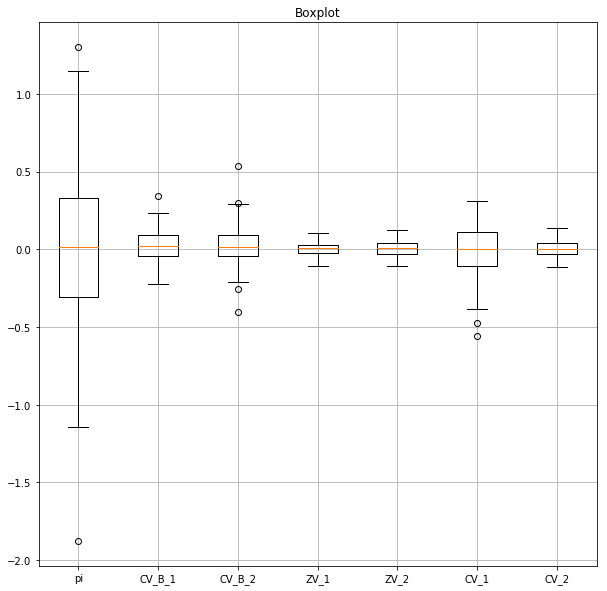

In [305]:
all_data.append(res_zv_1)
all_data.append(res_zv_2)
all_data.append(res_cv_1)
all_data.append(res_cv_2) 

plt.figure(figsize=(10,10))
plt.boxplot(all_data)
plt.xticks(np.arange(1,8), ('pi', 'CV_B_1','CV_B_2', 'ZV_1', 'ZV_2', 'CV_1', 'CV_2'))
plt.title('Boxplot')
plt.grid()
plt.show()

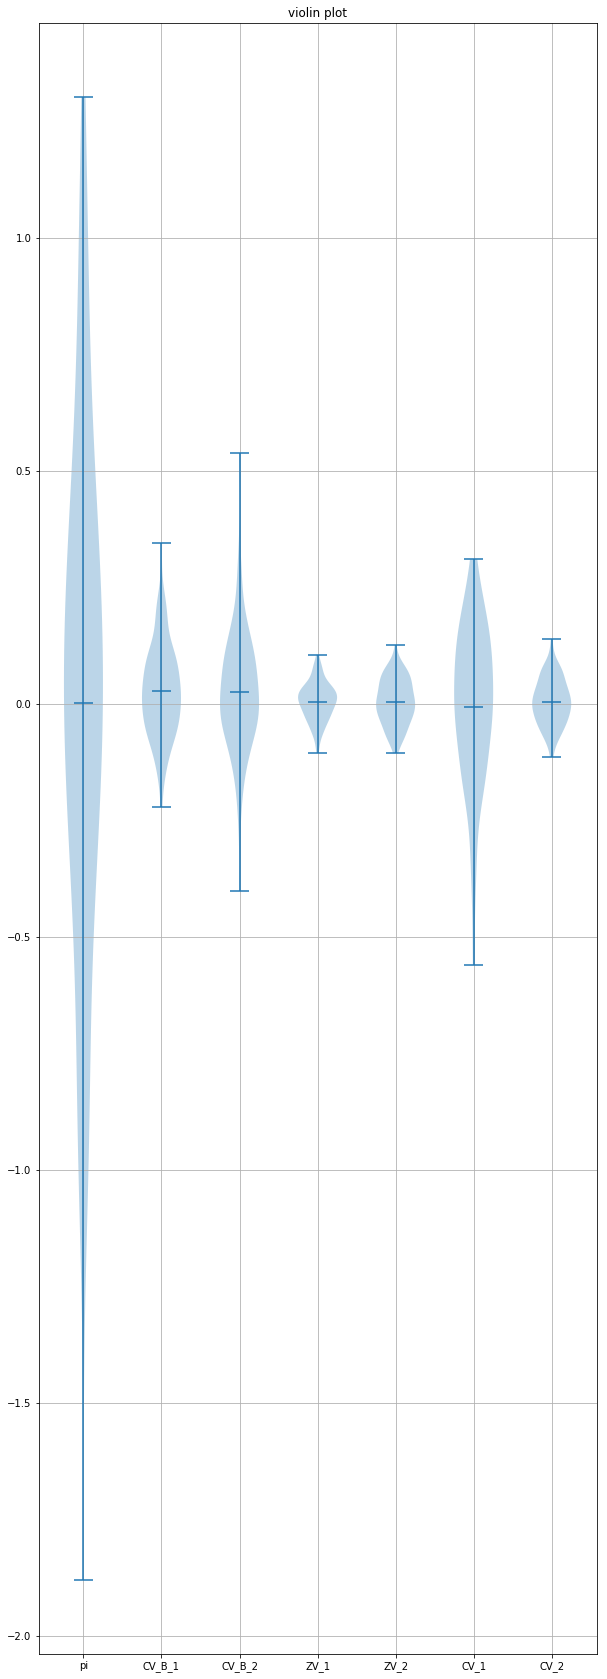

In [306]:
plt.figure(figsize=(10,30))
plt.violinplot(
        all_data, showmeans=True, showmedians=False)
plt.title('violin plot')
plt.xticks(np.arange(1,8), ('pi', 'CV_B_1','CV_B_2', 'ZV_1', 'ZV_2', 'CV_1', 'CV_2'))
plt.grid()
plt.show()